# **PREDICTING HOUSE PRICES**

**In this notebook, we are going to build a machine learning model that predicts prices of houses based on historical data.**

## Data: ##
The dataset we're gonna work with is the Ames Housing dataset. It contains 80 attributes for 2,930 properties in Ames, Iowa and was completed in 2011. The attributes include number and type of rooms, location specific data and special features of the property (pool, fireplace etc.). Each row in the dataset represents a single house.

## Goal: ##
Predict sale price of a house as accurately as possible, based on data about the house features and location.

## Models: ##


## Evaluation: ##


## Result: ##



Let's take a look at our training data:

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
import warnings
from scipy import stats, special

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import RobustScaler

from sklearn.pipeline import make_pipeline

# DATA #

In [2]:

# Import train and test data
house_train = pd.read_csv("./data/train.csv")
house_test = pd.read_csv("./data/test.csv")

In [3]:
# Take a look at the first 5 rows of the training data
house_train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house_test.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# Take a look at additional info regarding the training data
house_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

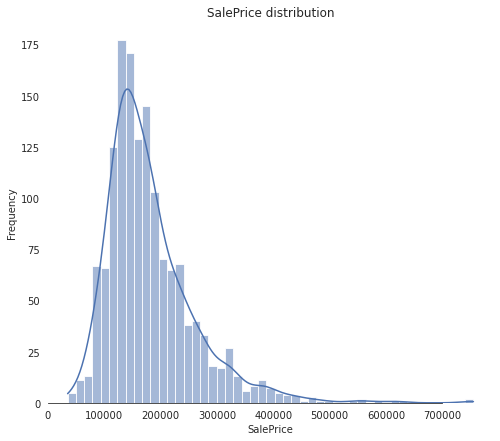

In [6]:
# Plot a histogram of the target column (SalePrice)
sns.set_style("white")
sns.set_color_codes(palette = "deep")
fig, ax = plt.subplots(figsize = [8, 7])
sns.histplot(house_train["SalePrice"], kde = "True", color = "b") # kde: Kernel Density Estimate
                                                                  # not using displot because that's a figure-level function
ax.xaxis.grid(False)
ax.set(ylabel = "Frequency")
ax.set(xlabel = "SalePrice")
ax.set(title = "SalePrice distribution")
sns.despine(trim = True, left = True)
plt.show()


In [7]:
# Look at how spread out and symmetric the graph is
print("Kurtosis: %f" % house_train["SalePrice"].kurt())
print("Skewness: %f" % house_train["SalePrice"].skew())

Kurtosis: 6.536282
Skewness: 1.882876



The kurtosis and skewness values tell us that the distribution has a pretty sharp peak and that it is "leaning" to the left, i. e., there is a high number of cheaper houses and there are a few extremely expensive ones.


Now, let's look at the features. Start by getting to know numeric features.



In [8]:
# Filter numeric features
numeric_datatypes = ["int16", "int32", "int64", "float16", "float32", "float64"]
numeric_cols = []
for i in house_train.columns:
    if house_train[i].dtype in numeric_datatypes:
        if i in ["TotalSF", "Total_Bathrooms","Total_porch_sf","haspool","hasgarage","hasbsmt","hasfireplace"]:
            pass
        else:
            numeric_cols.append(i)     

Now, let's look at the correlation between features of the houses and the sale price. To do this, we plot the distribution of the numeric data. Data points far away from the rest are called outliers and make predictions harder.

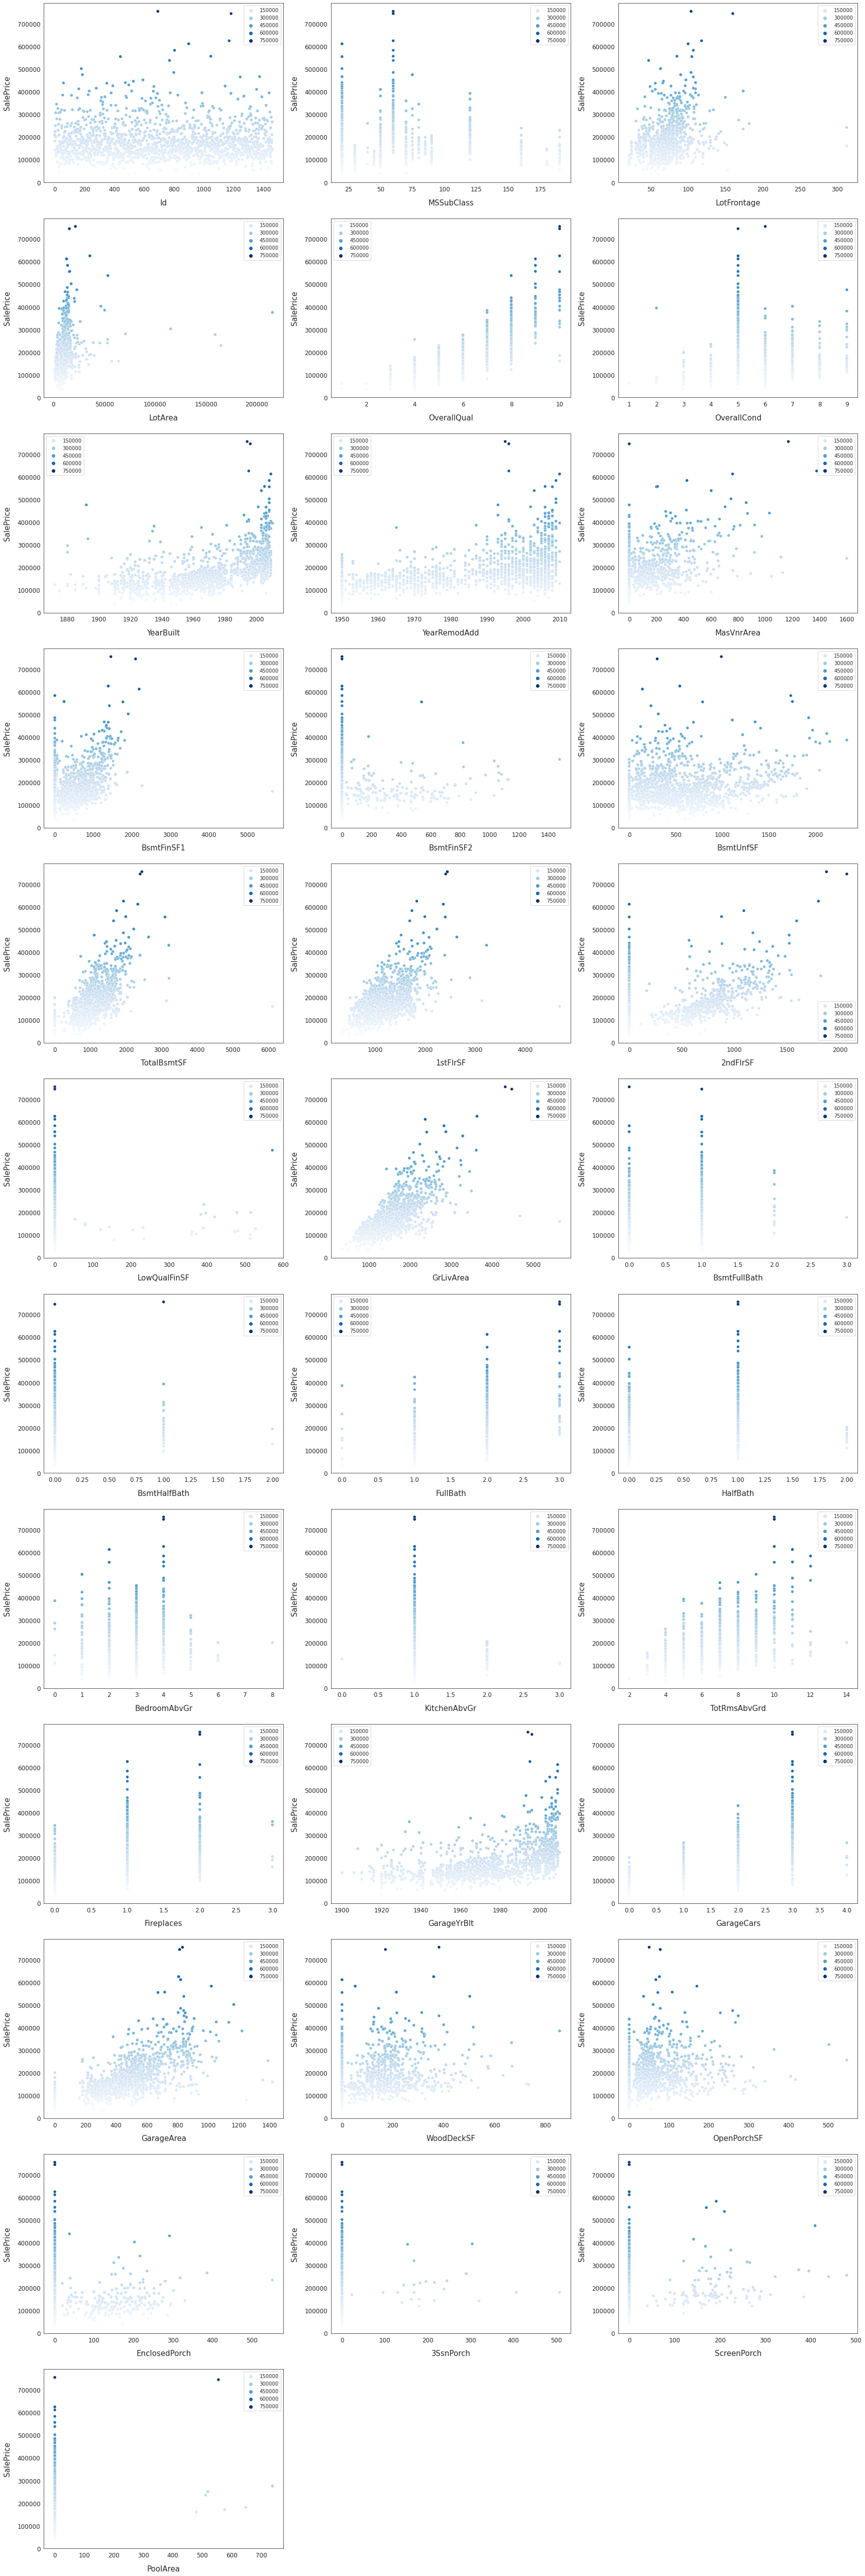

In [9]:
# Plot numeric data

fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (12, 120))
plt.subplots_adjust(right = 2)
plt.subplots_adjust(top = 2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(house_train[numeric_cols]), 1):
    if(feature == "MiscVal"):
        break
    plt.subplot(len(list(numeric_cols)), 3, i)
    sns.scatterplot(x = feature, y = "SalePrice", hue = "SalePrice", palette = "Blues", data = house_train)
        
    plt.xlabel("{}".format(feature), size = 15,labelpad = 12.5)
    plt.ylabel("SalePrice", size = 15, labelpad = 12.5)
    
    for j in range(2):
        plt.tick_params(axis = "x", labelsize = 12)
        plt.tick_params(axis = "y", labelsize = 12)
    
    plt.legend(loc = "best", prop = {"size": 10})
        
plt.show()

Let's analyze this topic also through a correlation matrix.

/tmp/ipykernel_7941/3061024875.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = house_train.corr()


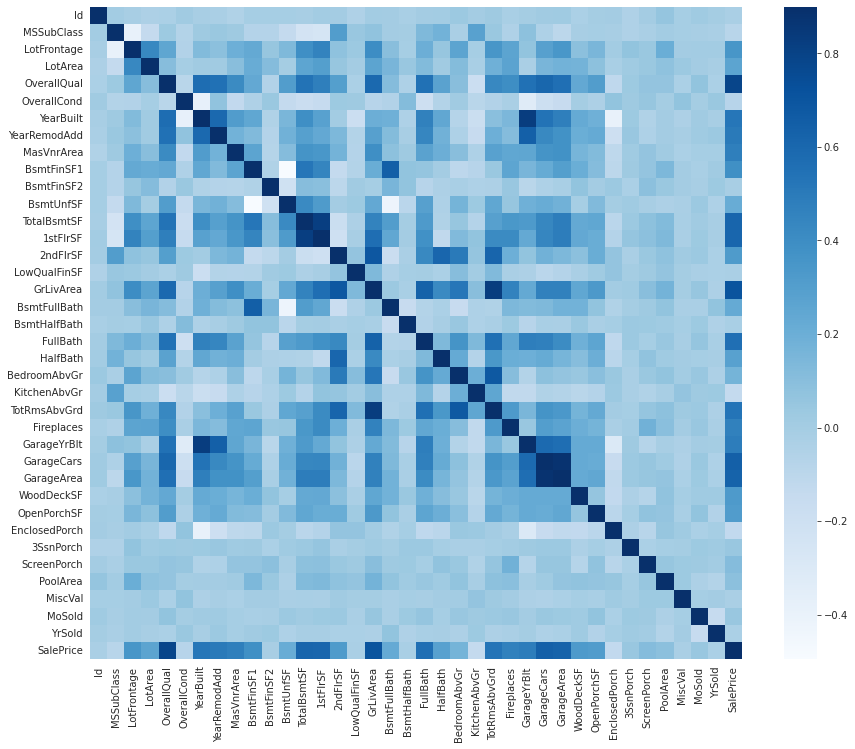

In [10]:
corr_matrix = house_train.corr()
plt.subplots(figsize = (15, 12))
sns.heatmap(corr_matrix, vmax = 0.9, cmap = "Blues", square = True);

We can see that the feature that correlates the strongest with the sale price is overall quality, which shouldn't come as a surprise. The second most influental on the sale price is the gross living area, which is also something we could suspect.

Let's analyze strongly correlating features more closely.

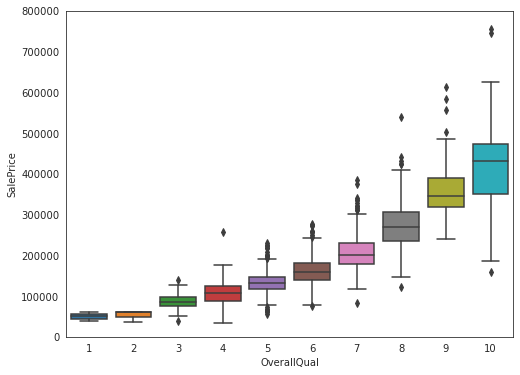

In [11]:
data = pd.concat([house_train["SalePrice"], house_train["OverallQual"]], axis = 1)
f, ax = plt.subplots(figsize = (8, 6))
fig = sns.boxplot(x = house_train["OverallQual"], y = house_train["SalePrice"], data = data)
fig.axis(ymin = 0, ymax = 800000);

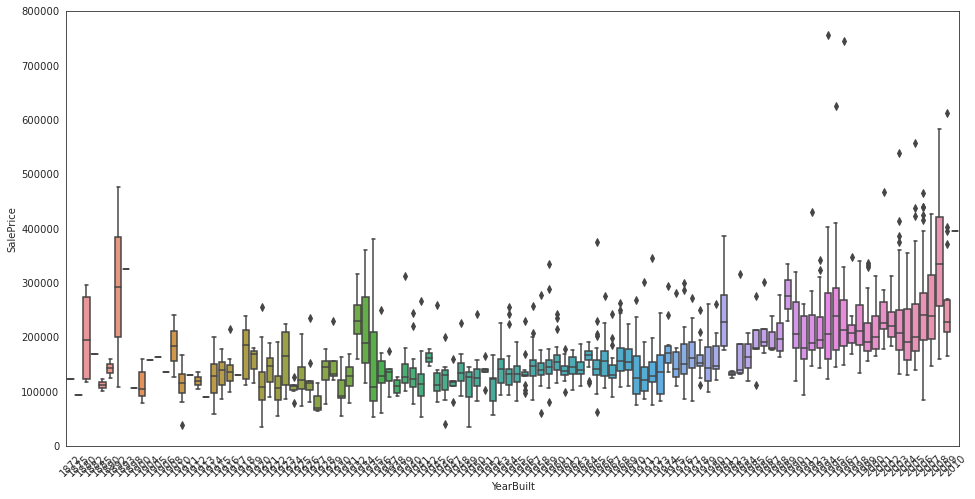

In [12]:
data = pd.concat([house_train["SalePrice"], house_train["YearBuilt"]], axis = 1)
f, ax = plt.subplots(figsize = (16, 8))
fig = sns.boxplot(x = house_train["YearBuilt"], y = house_train["SalePrice"], data = data)
fig.axis(ymin = 0, ymax = 800000)
plt.xticks(rotation = 45);



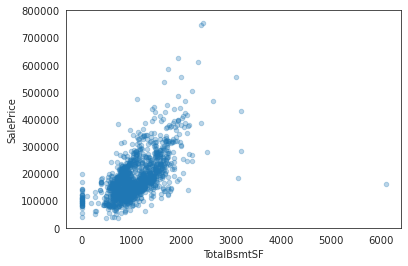

In [13]:
data = pd.concat([house_train["SalePrice"], house_train["TotalBsmtSF"]], axis = 1)
data.plot.scatter(x = "TotalBsmtSF", y = "SalePrice", alpha = 0.3, ylim = (0, 800000));

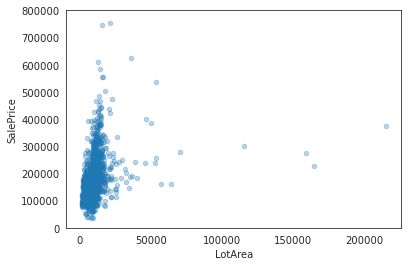

In [14]:
data = pd.concat([house_train["SalePrice"], house_train["LotArea"]], axis = 1)
data.plot.scatter(x = "LotArea", y = "SalePrice", alpha = 0.3, ylim = (0, 800000));

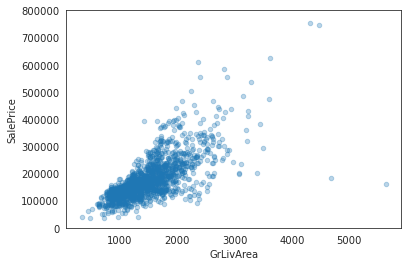

In [15]:
data = pd.concat([house_train["SalePrice"], house_train["GrLivArea"]], axis = 1)
data.plot.scatter(x = "GrLivArea", y = "SalePrice", alpha = 0.3, ylim = (0, 800000));

Now, let's prepare our data for model training.
First, we need to remove the IDs as we won't be using them to train our models.

In [16]:
house_train.reset_index(drop = True, inplace = True)
house_test.reset_index(drop = True, inplace = True)
house_train.shape, house_test.shape


((1460, 81), (1459, 80))

## Feature Engineering

Now it's time to do some feature engineering. Let's look again at the plot of the target column (sale price).

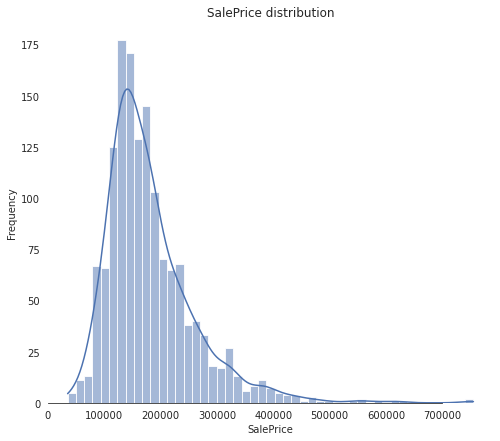

In [17]:
sns.set_style("white")
sns.set_color_codes(palette = "deep")
fig, ax = plt.subplots(figsize = (8, 7))
sns.histplot(house_train["SalePrice"], color = "b", kde = True);
ax.xaxis.grid(False)
ax.set(ylabel = "Frequency")
ax.set(xlabel = "SalePrice")
ax.set(title = "SalePrice distribution")
sns.despine(trim = True, left = True)
plt.show()

As we can see from the image above, the sale price graph is positively skewed. This can be a problem as most machine learning models don't do well on normal distributions with significant skew.
To change this, we can take the logarithm of the sale price.

In [18]:
house_train["SalePrice"] = np.log1p(house_train["SalePrice"])

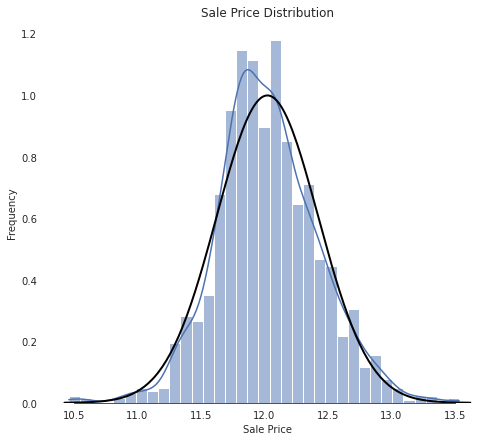

In [19]:
# Define function to plot a normal distribution

def normal(mean, std, color = "black"):
    x = np.linspace(mean - 4 * std, mean + 4 * std, 200)
    p = stats.norm.pdf(x, mean, std)
    z = plt.plot(x, p, color, linewidth = 2)

sns.set_style("white")
sns.set_color_codes(palette = "deep")
fig, ax = plt.subplots(figsize = (8, 7))
sns.histplot(house_train["SalePrice"], stat = "density", color = "b", kde = True)
ax.xaxis.grid(False)
ax.set(xlabel = "Sale Price", ylabel = "Frequency", title = "Sale Price Distribution")
sns.despine(trim = True, left = True)

# Plot normal distribution with no skew or kurtosis
normal(house_train["SalePrice"].mean(), house_train["SalePrice"].std())

plt.show();

In the next step, we're gonna remove outliers. These are single data points far away from the rest of the data and are therefore not representative for the dataset as a whole.

In [20]:
house_train.drop(house_train[(house_train["OverallQual"] < 5) & (house_train["SalePrice"] > 200000)].index, inplace = True)
house_train.drop(house_train[(house_train["GrLivArea"] > 4500) & (house_train["SalePrice"] < 300000)].index, inplace = True)
house_train.reset_index(drop = True, inplace = True)

In [21]:
# Create labels and features containers
house_train_labels = house_train["SalePrice"].reset_index(drop = True)
house_train_features = house_train.drop(["SalePrice"], axis = 1)
house_test_features = house_test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([house_train_features, house_test_features]).reset_index(drop = True)
all_features.shape

(2917, 80)

We're now gonna fill in gaps in the data with appropriate values.

In [22]:
# Determine fraction of missing values
def missingCalc(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    missing_fractions = {}
    for i in range(len(df_cols)):
        missing_fractions.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return missing_fractions

missing = missingCalc(all_features)
df_miss = sorted(missing.items(), key = lambda x: x[1], reverse = True)
print("Percentage of missing data")
df_miss[:10]



Percentage of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45)]

There's quite a lot missing data. Let's visualize that.

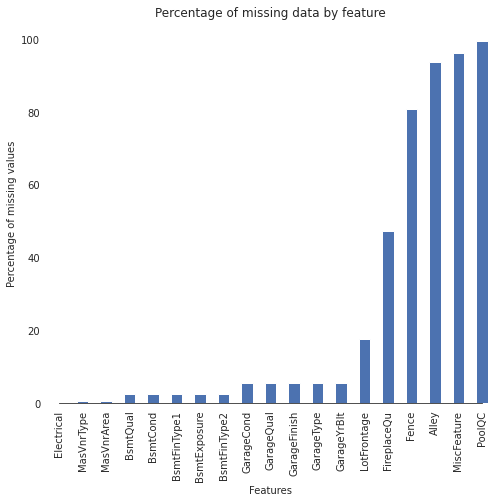

In [23]:
# Visualize missing values
sns.set_style("white")
sns.set_color_codes(palette = "deep")
fig, ax = plt.subplots(figsize = (8, 7))
missing = round(house_train.isnull().mean() * 100, 2)
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing.plot.bar(color = "b")
ax.xaxis.grid(False)
ax.set(ylabel = "Percentage of missing values")
ax.set(xlabel = "Features")
ax.set(title = "Percentage of missing data by feature")
sns.despine(trim = True, left = True)

We're now gonna fill the gaps in the data with suitable values. This helps the machine learning model to make more accurate predictions.

In [24]:
# Convert non-numeric columns that store values as numbers to strings
all_features["MSSubClass"] = all_features["MSSubClass"].apply(str)
all_features["YrSold"] = all_features["YrSold"].astype(str)
all_features["MoSold"] = all_features["MoSold"].astype(str)

Let's define a function to fill missing values in data.

In [25]:

def fillMissingData(features):
    
    # The data description states that "NA" refers to typical ("Typ") values
    features["Functional"] = features["Functional"].fillna("Typ")

    # Replace the missing values in each of the columns below with their mode
    features["Electrical"] = features["Electrical"].fillna("SBrkr")
    features["KitchenQual"] = features["KitchenQual"].fillna("TA")
    features["Exterior1st"] = features["Exterior1st"].fillna(features["Exterior1st"].mode()[0])
    features["Exterior2nd"] = features["Exterior2nd"].fillna(features["Exterior2nd"].mode()[0])
    features["SaleType"] = features["SaleType"].fillna(features["SaleType"].mode()[0])
    features["MSZoning"] = features.groupby("MSSubClass")["MSZoning"].transform(lambda x: x.fillna(x.mode()[0]))

    # The data description states that "NA" refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")

    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ("GarageYrBlt", "GarageArea", "GarageCars"):
        features[col] = features[col].fillna(0)

    # Replacing the missing values with "None"
    for col in ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]:
        features[col] = features[col].fillna("None")

    # "NaN" values for these categorical basement features mean there's no basement
    for col in ("BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"):
        features[col] = features[col].fillna("None")
        
    # Group features by neighborhood, and fill missing value by the median LotFrontage of the neighborhood
    features["LotFrontage"] = features.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

    # For the missing values in the rest of the categorical features, there's not enough information to fill them properly, so they're filled with "None"
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna("None"))
        
    # The same is true for the numerical features, so the gaps are filled with zeros
    numeric_dtypes = ["int16", "int32", "int64", "float16", "float32", "float64"]
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_features = fillMissingData(all_features)


In [26]:
# Check if we handled all the missing values
missing = missingCalc(all_features)
missing_sorted = sorted(missing.items(), key = lambda x: x[1], reverse = True)
print("Percentage of missing data")
missing_sorted[:10]


Percentage of missing data


[('Id', 0.0),
 ('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0)]

We can see that there are no more missing values, so we can move on to the next step: fixing skewed features.

In [27]:
# Fetch all numeric features
numeric_dtypes = ["int16", "int32", "int64", "float16", "float32", "float64"]
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

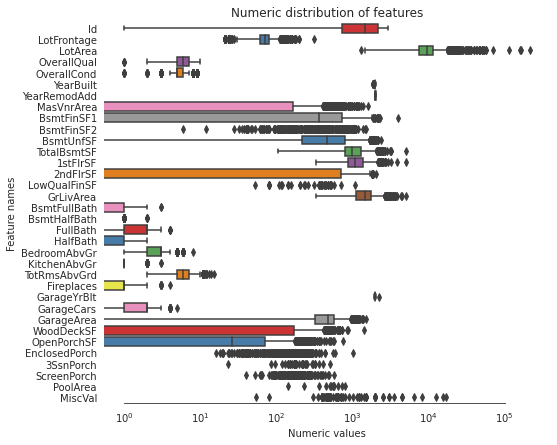

In [28]:


# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize = (8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data = all_features[numeric] , orient = "h", palette = "Set1")
ax.xaxis.grid(False)
ax.set(ylabel = "Feature names")
ax.set(xlabel = "Numeric values")
ax.set(title = "Numeric distribution of features")
sns.despine(trim = True, left = True)



In [29]:


# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: stats.skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with skew > 0.5: ".format(high_skew.shape[0]))
skewness = pd.DataFrame({"Skew": high_skew})
skew_features.head(10)



There are 25 numerical features with skew > 0.5: 


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

In [30]:
# Normalize skewed features
for i in skew_index:
    all_features[i] = special.boxcox1p(all_features[i], stats.boxcox_normmax(all_features[i] + 1))

/usr/lib/python3/dist-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/lib/python3/dist-packages/scipy/stats/_stats_py.py:4098: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


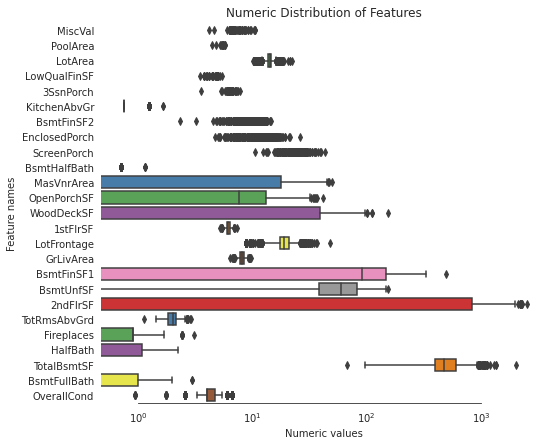

In [31]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize = (8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data = all_features[skew_index] , orient = "h", palette = "Set1")
ax.xaxis.grid(False)
ax.set(ylabel = "Feature names")
ax.set(xlabel = "Numeric values")
ax.set(title = "Numeric Distribution of Features")
sns.despine(trim = True, left = True)

# Create interesting features

To help the machine learning models recognize complex pattens, we're gonna create some features we think could be of significance for the price of the house (e. g., total area of rooms).

In [32]:
all_features["BsmtFinType1_Unf"] = (all_features["BsmtFinType1"] == "Unf") * 1
all_features["HasWoodDeck"] = (all_features["WoodDeckSF"] == 0) * 1
all_features["HasOpenPorch"] = (all_features["OpenPorchSF"] == 0) * 1
all_features["HasEnclosedPorch"] = (all_features["EnclosedPorch"] == 0) * 1
all_features["Has3SsnPorch"] = (all_features["3SsnPorch"] == 0) * 1
all_features["HasScreenPorch"] = (all_features["ScreenPorch"] == 0) * 1
all_features["YearsSinceRemodel"] = all_features["YrSold"].astype(int) - all_features["YearRemodAdd"].astype(int)
all_features["Total_Home_Quality"] = all_features["OverallQual"] + all_features["OverallCond"]
all_features = all_features.drop(["Utilities", "Street", "PoolQC",], axis = 1)
all_features["TotalSF"] = all_features["TotalBsmtSF"] + all_features["1stFlrSF"] + all_features["2ndFlrSF"]
all_features["YrBltAndRemod"] = all_features["YearBuilt"] + all_features["YearRemodAdd"]

all_features["Total_sqr_footage"] = (all_features["BsmtFinSF1"] + all_features["BsmtFinSF2"] +
                                 all_features["1stFlrSF"] + all_features["2ndFlrSF"])
all_features["Total_Bathrooms"] = (all_features["FullBath"] + (0.5 * all_features["HalfBath"]) +
                               all_features["BsmtFullBath"] + (0.5 * all_features["BsmtHalfBath"]))
all_features["Total_porch_sf"] = (all_features["OpenPorchSF"] + all_features["3SsnPorch"] +
                              all_features["EnclosedPorch"] + all_features["ScreenPorch"] +
                              all_features["WoodDeckSF"])
all_features["TotalBsmtSF"] = all_features["TotalBsmtSF"].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features["2ndFlrSF"] = all_features["2ndFlrSF"].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features["GarageArea"] = all_features["GarageArea"].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features["GarageCars"] = all_features["GarageCars"].apply(lambda x: 0 if x <= 0.0 else x)
all_features["LotFrontage"] = all_features["LotFrontage"].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features["MasVnrArea"] = all_features["MasVnrArea"].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features["BsmtFinSF1"] = all_features["BsmtFinSF1"].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features["haspool"] = all_features["PoolArea"].apply(lambda x: 1 if x > 0 else 0)
all_features["has2ndfloor"] = all_features["2ndFlrSF"].apply(lambda x: 1 if x > 0 else 0)
all_features["hasgarage"] = all_features["GarageArea"].apply(lambda x: 1 if x > 0 else 0)
all_features["hasbsmt"] = all_features["TotalBsmtSF"].apply(lambda x: 1 if x > 0 else 0)
all_features["hasfireplace"] = all_features["Fireplaces"].apply(lambda x: 1 if x > 0 else 0)

## Transform features

Now we're gonna create some more features. These will be the squares of the logs of numerical features.

In [33]:
def createLog(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol = pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + "_log"
        m += 1
    return res

log_features = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", 
                 "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", 
                 "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", 
                 "TotRmsAbvGrd", "Fireplaces", "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", 
                 "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", "YearRemodAdd", "TotalSF"]

all_features = createLog(all_features, log_features)

In [34]:
def createSquare(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol = pd.Series(res[l] * res[l]).values)   
        res.columns.values[m] = l + "_sq"
        m += 1
    return res

squared_features = ["YearRemodAdd", "LotFrontage_log", 
                    "TotalBsmtSF_log", "1stFlrSF_log", "2ndFlrSF_log", "GrLivArea_log",
                    "GarageCars_log", "GarageArea_log"]

all_features = createSquare(all_features, squared_features)


In [35]:
all_features = pd.get_dummies(all_features).reset_index(drop = True)
all_features.shape

(2917, 380)

In [36]:
all_features.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,18.144573,13.833054,7,3.991517,2003,2003,19.433175,144.117862,0.0,...,0,0,0,1,0,0,0,0,1,0
1,2,20.673625,14.117918,6,6.000033,1976,1976,54.598150,181.719186,0.0,...,0,0,0,1,0,0,0,0,1,0
2,3,18.668047,14.476512,7,3.991517,2001,2002,17.768840,110.441033,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4,17.249651,14.106196,7,3.991517,1915,1970,54.598150,61.795315,0.0,...,0,0,0,1,1,0,0,0,0,0
4,5,21.314283,15.022008,8,3.991517,2000,2000,25.404164,136.624601,0.0,...,0,0,0,1,0,0,0,0,1,0


In [37]:
all_features.shape

(2917, 380)

In [38]:
# Remove any duplicated column names
all_features = all_features.loc[:,~all_features.columns.duplicated()]


In [39]:
all_features.shape

(2917, 379)

Now, we have to reassemble the training and test data sets.

In [40]:
X_train = all_features.iloc[:len(house_train_labels), :]
X_test = all_features.iloc[len(house_train_labels):, :]
X_train.shape, house_train_labels.shape, X_test.shape

((1458, 379), (1458,), (1459, 379))

Before we begin training, let's visualize the data once more.

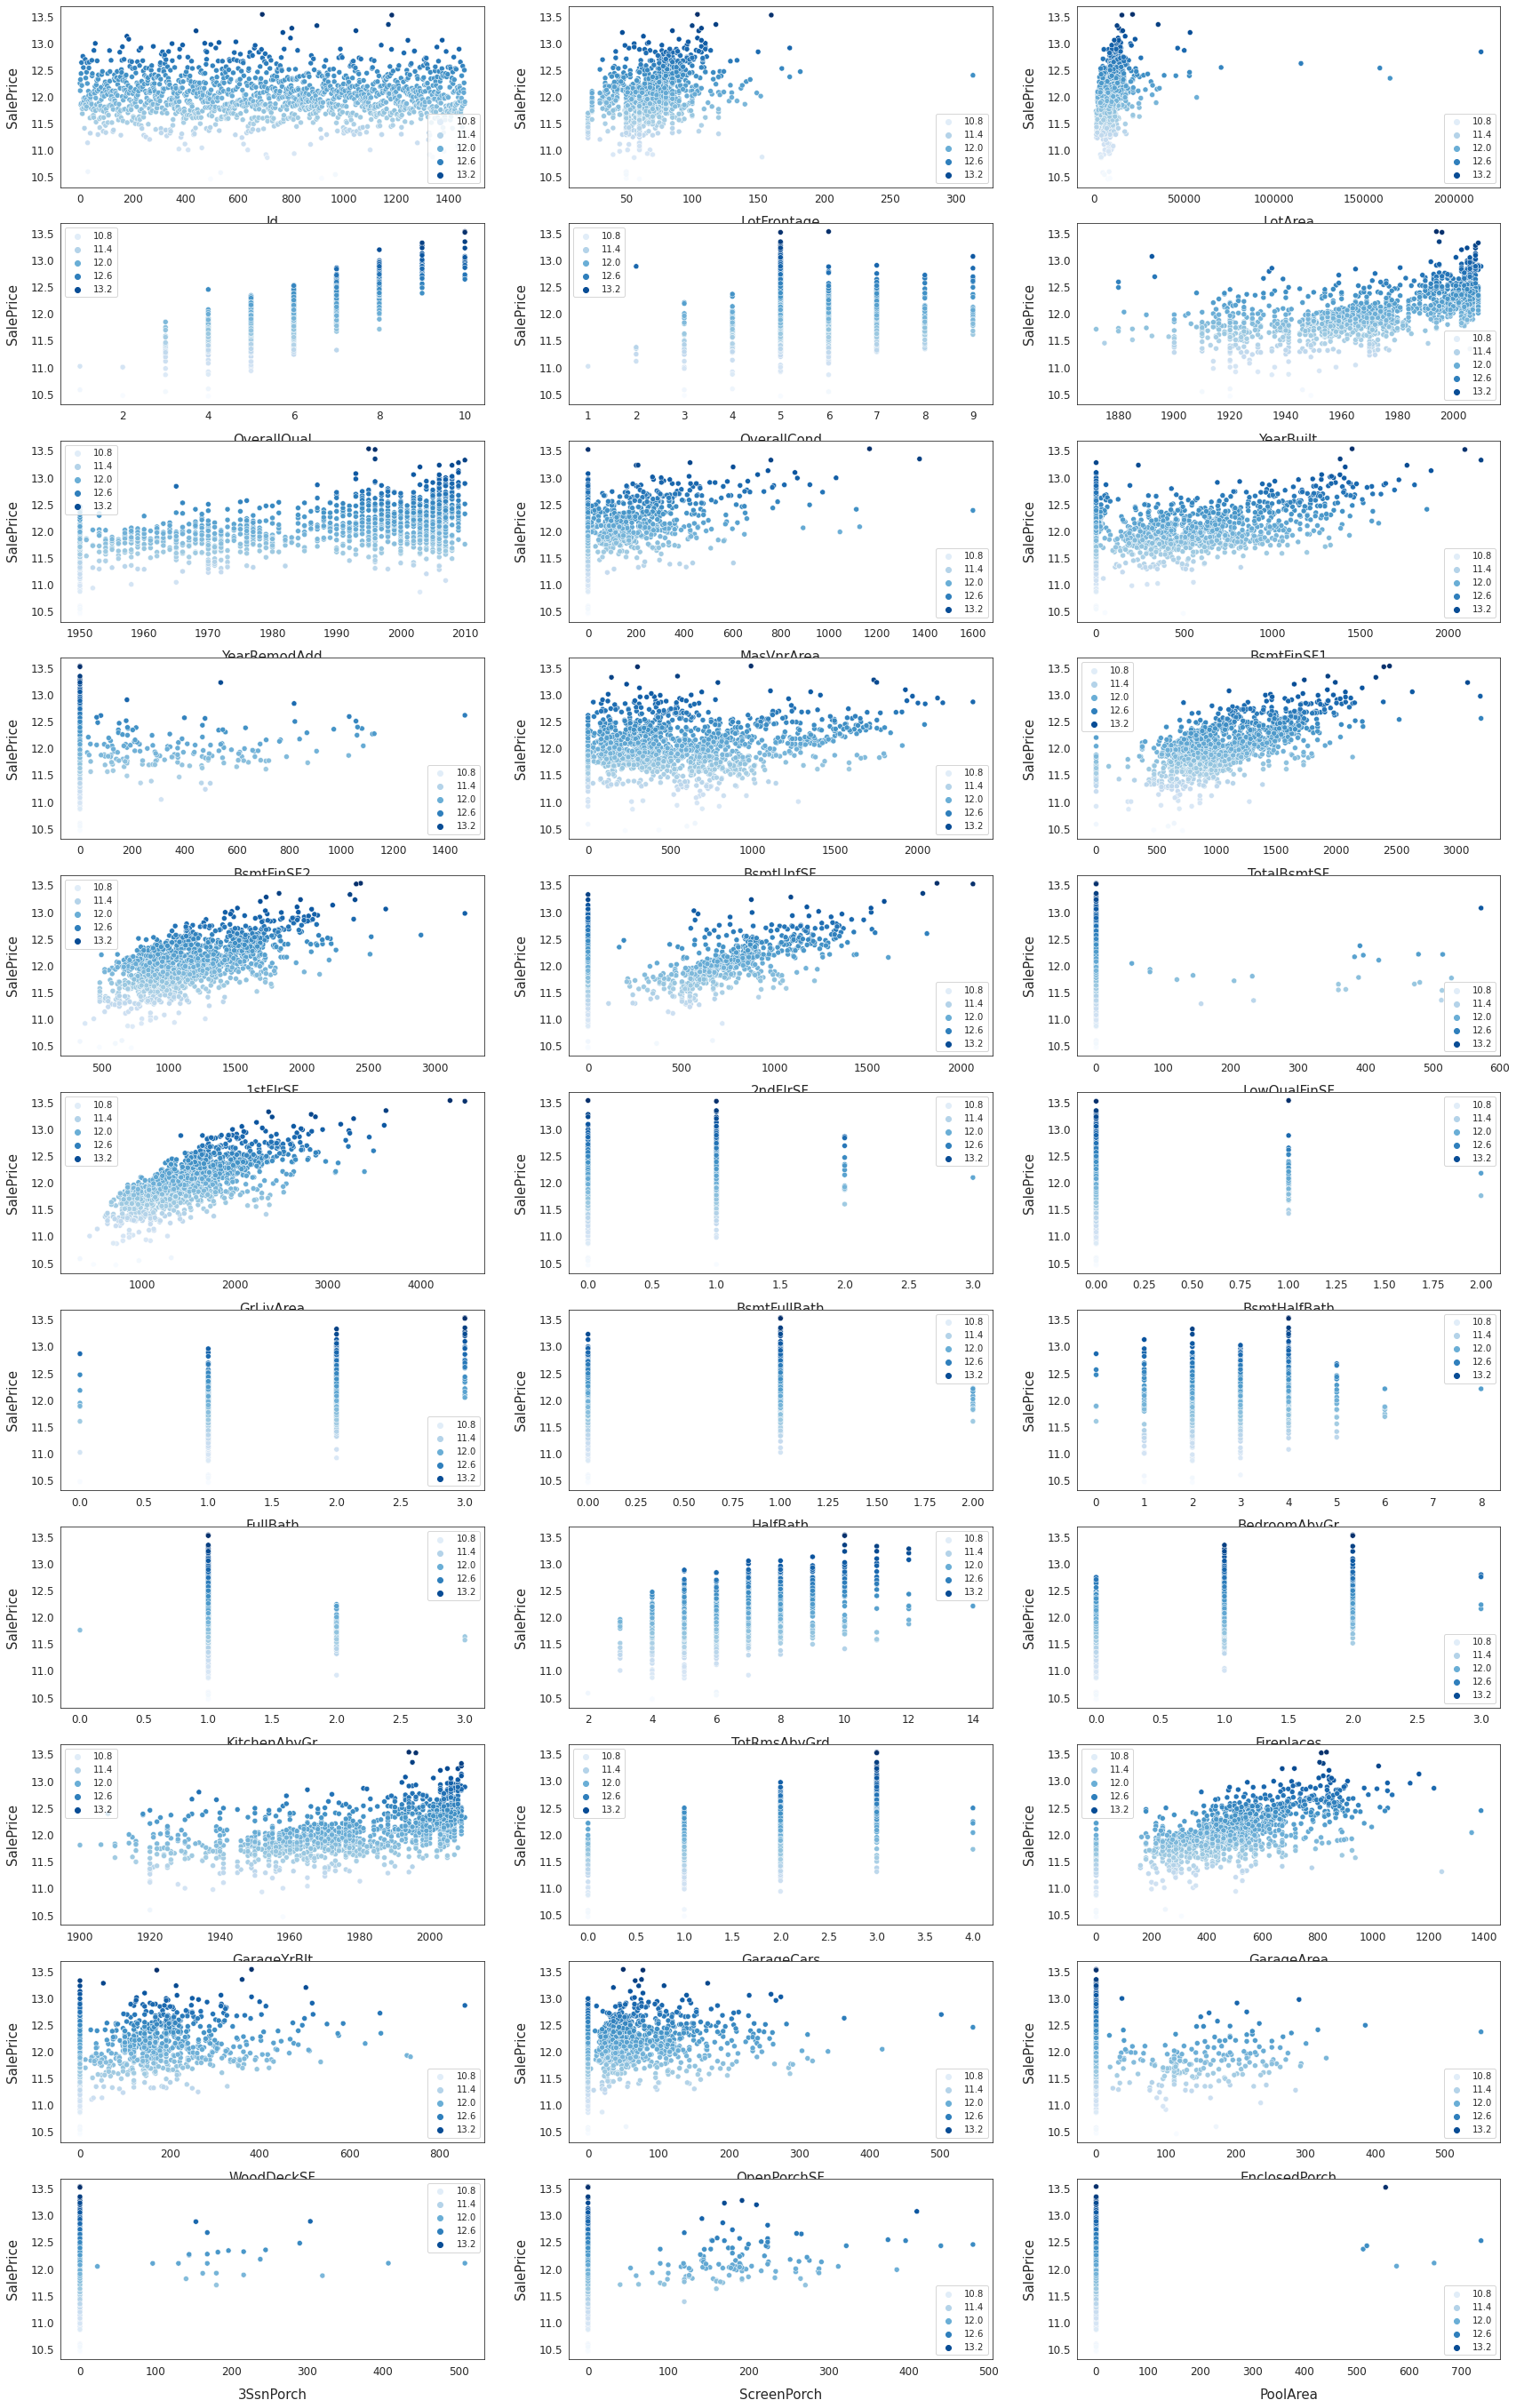

In [41]:
# Find numeric features
numeric = []
for i in X_train.columns:
    if X_train[i].dtype in numeric_dtypes:
        if i in ["TotalSF", "Total_Bathrooms", "Total_porch_sf", "haspool", "hasgarage", "hasbsmt", "hasfireplace"]:
            pass
        else:
            numeric.append(i)

# Visualize some more outliers in the data
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12, 150))
plt.subplots_adjust(right = 2)
plt.subplots_adjust(top = 2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(X_train[numeric]), 1):
    if(feature == "MiscVal"):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x = feature, y = "SalePrice", hue = "SalePrice", palette = "Blues", data = house_train)
        
    plt.xlabel("{}".format(feature), size = 15,labelpad = 12.5)
    plt.ylabel("SalePrice", size = 15, labelpad = 12.5)
    
    for j in range(2):
        plt.tick_params(axis = "x", labelsize = 12)
        plt.tick_params(axis = "y", labelsize = 12)
    
    plt.legend(loc = "best", prop = {"size": 10})
        
plt.show()

# Training models

7 models are to be trained:  lightgbm regressors, xgboost, ridge, gradient boosting, svr, and random forest. A meta StackingCVRegressor is also gonna be trained. Fo the end result, the predictions of the 7 models will be weighted according to their overall performance. 12-fold cross-validation will be used to determine the performance of the models.

In [42]:
# Set up cross validation folds
kf = KFold(n_splits = 12, random_state = 42, shuffle = True)

In [43]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X = X_train):
    rmse = np.sqrt(-cross_val_score(model, X, house_train_labels, scoring = "neg_mean_squared_error", cv = kf))
    return (rmse)

In [50]:
# Set up models

# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective = "regression", 
                       num_leaves = 6,
                       learning_rate = 0.01, 
                       n_estimators = 7000,
                       max_bin = 200, 
                       bagging_fraction = 0.8,
                       bagging_freq = 4, 
                       bagging_seed = 8,
                       feature_fraction = 0.2,
                       feature_fraction_seed = 8,
                       min_sum_hessian_in_leaf = 11,
                       verbose = -1,
                       random_state = 42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate = 0.01,
                       n_estimators = 6000,
                       max_depth = 4,
                       min_child_weight = 0,
                       gamma = 0.6,
                       subsample = 0.7,
                       colsample_bytree = 0.7,
                       objective = "reg:linear",
                       nthread = -1,
                       scale_pos_weight = 1,
                       seed = 27,
                       reg_alpha = 0.00006,
                       random_state = 42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas = ridge_alphas, cv = kf))
